In [2]:
from scipy import stats
import pandas as pd
from adjustText import adjust_text
import statsmodels.stats.proportion as ssp
import statsmodels.api as sm
import sys
sys.path.append('../figures/scripts/')
import funclib as flib

### A model to predict alpha based on exposure to developmental stages

Load data

In [60]:
directory = "../"

complete_data = pd.read_csv("{}/data/Table_S2.csv".format(directory))
complete_data["Total_phased_dnms"] = complete_data["Maternal_dnms"] + complete_data["Paternal_dnms"]

species2common = flib.df2dict(complete_data, "Species", "Common_name")

The model using parameters from evolutionary data

In [15]:
E = 5/3e9

predicted_alphas_l = []

for i,r in complete_data[complete_data.Group=="Mammals"].iterrows():
    
    # Parameters
    p_age, m_age = r.Generation_time_y, r.Generation_time_y
    y_rate = r.MutPerYearUCSC/1e6
    gen_rate = p_age*y_rate
    
    # Predict alpha
    pred_alphas = []
    mu_f, mu_m = flib.get_parental_age_effects(gen_rate, m_age, p_age, E, 4)
    pred_alpha = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
    
    # With different p-to-m generation time ratio
    average_age = p_age
    pred_alpha_ratios = {}
    
    for name,ratio in zip(["min", "max"],[0.7, 1.3]):
        
        m_age, p_age = flib.ratioG(average_age, ratio)
        mu_f, mu_m = flib.get_parental_age_effects_yrate(y_rate, m_age, p_age, E, 4)
        pred_alpha_ratios[name] = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
        
    # Keep data for dataframe
    predicted_alphas_l.append([r.Species, pred_alpha, pred_alpha_ratios["min"], pred_alpha_ratios["max"]])

# Build dataframe
predicted_alphas = pd.DataFrame(predicted_alphas_l)
predicted_alphas.columns = ["species","predicted_alpha", "predicted_alpha_lwr", "predicted_alpha_upr"]

predicted_alphas["alpha"] = complete_data.Alpha
predicted_alphas["max_alpha"] = complete_data.Alpha_upr
predicted_alphas["min_alpha"] = complete_data.Alpha_lwr

The model using parameters from pedigree data

In [16]:
predicted_alphas_dnms = pd.DataFrame()
cols = ["Species", "Common_name", "Age", "Paternal", "Maternal", "dnm_alpha", "maternal_slope", "paternal_slope", "predicted_alpha_dnms", "total_muts", "trios","maternal_age","paternal_age"]

for i,r in complete_data[complete_data.MutRatePerGenDNMs>0].iterrows():
    
    sp = r.Species
    
    # Skip flycatcher
    if sp=="Ficedula_albicollis":
        continue
        
    # Useful info
    cn = species2common[sp]
    m,p = r.Maternal_dnms, r.Paternal_dnms
    alpha = p/m
    trios = r.n_Trios
    
    # Parameters
    p_age, m_age = r.Paternal_age_y, r.Maternal_age_y
    gen_rate = r.MutRatePerGenDNMs
    
    # Predict alpha
    mu_f, mu_m = flib.get_parental_age_effects(gen_rate, m_age, p_age, E, 4)
    pred_alpha = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
    
    # Build dataframe
    c_df = pd.DataFrame([sp, cn, np.mean([p_age,m_age]), p, m, alpha, mu_f, mu_m, pred_alpha, p+m, trios, m_age, p_age]).transpose()
    c_df.columns = cols
    predicted_alphas_dnms = pd.concat([predicted_alphas_dnms,c_df])

Save results

In [17]:
evo_dict = flib.df2dict(predicted_alphas, "species", "predicted_alpha")
dnm_dict = flib.df2dict(predicted_alphas_dnms, "Species", "predicted_alpha_dnms")

Me = int(np.round(E*3e9))
complete_data["Predicted_alpha_evo_Me{}".format(Me)] = [evo_dict[sp] if sp in evo_dict else np.nan for sp in complete_data.Species]
complete_data["Predicted_alpha_dnm_Me{}".format(Me)] = [dnm_dict[sp] if sp in dnm_dict else np.nan for sp in complete_data.Species]

In [26]:
subd.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Species', 'Common_name', 'Group',
       'Alpha', 'Alpha_lwr', 'Alpha_upr', 'Xz_a', 'Xz_a_lwr', 'Xz_a_upr',
       'Alpha_dnm', 'Maternal_dnms', 'Paternal_dnms', 'n_Trios',
       'MutRatePerGenDNMs', 'Maternal_age_y', 'Paternal_age_y',
       'MutRatePerGenDNMs_ref', 'MutPerYearUCSC', 'Generation_time_y',
       'Generation_time_refs', 'AssemblyStatus', 'ScaffoldN50', 'ContigN50',
       'AssemblyAccession', 'Sex', 'Pi_het', 'Anage_Species',
       'TimeTree_Species', 'Maximum_longevity', 'Gestation_d',
       'Birth_weight_g', 'Adult_weight_g', 'Predicted_alpha_evo_Me5',
       'Predicted_alpha_dnm_Me5', 'Predicted_alpha_evo_Me3',
       'Predicted_alpha_dnm_Me3', 'Predicted_alpha_evo_Me7',
       'Predicted_alpha_dnm_Me7', 'Total_phased_dnms'],
      dtype='object')

In [27]:
subd[["Species","Paternal_age_y", "Maternal_age_y","MutRatePerGenDNMs"]]

,Species,Paternal_age_y,Maternal_age_y,MutRatePerGenDNMs
0,Bos_taurus,5.00,5.00,9.000000e-09
8,Homo_sapiens,31.63,27.60,1.290000e-08
10,Macaca_mulatta,10.53,7.88,6.750000e-09
11,Felis_catus,3.97,3.13,8.600000e-09
15,Mus_musculus,0.44,0.44,3.900000e-09
42,Papio_anubis,10.27,9.24,5.700000e-09
43,Pan_troglodytes,19.86,17.08,1.370000e-08
44,Gorilla_gorilla,13.50,19.50,1.120000e-08
45,Aotus_nancymaae,5.55,5.48,8.140000e-09


(0.7046243488578509, 0.03404735461185315)


<AxesSubplot:xlabel='Predicted_alpha_dnm_Me5', ylabel='Alpha_dnm'>

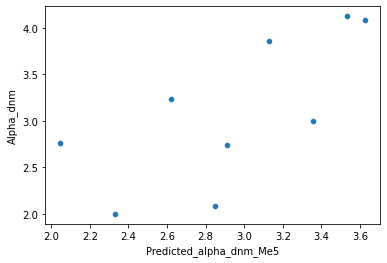

In [25]:
subd = complete_data[(complete_data.n_Trios>1) & (complete_data.Group!="Birds") & (complete_data.Species!="Microcebus_murinus") & (complete_data.Total_phased_dnms>30)]

print(stats.pearsonr(subd.Predicted_alpha_dnm_Me5, subd.Alpha_dnm))

sns.scatterplot(data=subd, x='Predicted_alpha_dnm_Me5', y="Alpha_dnm")

In [7]:
complete_data[[c for c in complete_data.columns if c not in ["Predicted_alpha_dnms","Predicted_alpha_evo"]]].to_csv("../data/Table_S2.csv")